<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/Adaptive_J_LocalSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
!pip install --upgrade torch


# Imports

In [115]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive

In [116]:
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Costants

In [117]:
NUM_EPOCHS = 5
BATCH_SIZE = 64
NUM_WORKER_LIST = [2]
LOCAL_STEPS = [8]
DELTA_MIN_INITIAL = 0.02
DELTA_MIN_MID = 0.005
DELTA_MIN_FINAL = 0.002
MIN_STEPS = 4
MAX_STEPS = 64
LR = 0.01
WD = 0.001
MOMENTUM = 0.9
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_PATH= "/content/drive/My Drive/Colab Notebooks/Traning_summary/"
CHECKPOINT_NAME = "checkpoint_last.pth"

## Model

In [118]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Function to get train, test and val dataset

In [119]:
def calulcate_mean_std(batch_size=BATCH_SIZE, verbose=True):
    # Transform only for caluclate meaning of the dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=0)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    if verbose:
      print("Mean: ", mean)
      print("Std: ", std)

    return mean, std

In [120]:
def get_dataset(batch_size=BATCH_SIZE, verbose=False):

    print("Start loading data with batch_size", batch_size)

    mean, std = calulcate_mean_std()

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    if verbose:
      print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    if verbose:
      for i, (inputs, labels) in enumerate(train_loader):
          print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
          if i == 10:
              break
      print(f"Data loading for 10 batches completed.")
      print(f"Training dataset size: {len(train_dataset)}")
      print(f"Validation dataset size: {len(val_dataset)}")
      print(f"Test dataset size: {len(test_dataset)}")


    print("Data load correctly...")

    return train_loader, val_loader, test_loader

In [121]:
class CheckpointSaver:

  def __init__(self, j, k, hyperparams, epochs, path=SAVE_PATH, checkpoint_name=CHECKPOINT_NAME):
    self.timestamp = time.strftime("%Y%m%d-%H%M%S")
    self.path = path
    self.checkpoint_name = checkpoint_name
    self.k = k
    self.j = j
    self.hyperparams = hyperparams
    self.epochs = epochs
    self.create_files()

  def create_files(self):
    os.makedirs(self.path, exist_ok=True)

    self.metrics_files = {
        'global_train_acc': os.path.join(self.path, f'adaptive_train_accuracy_{self.timestamp}_K={self.k}.txt'),
        'val_acc': os.path.join(self.path, f'adaptive_val_accuracy_{self.timestamp}_K={self.k}.txt'),
        'global_train_loss': os.path.join(self.path, f'adaptive_train_loss_{self.timestamp}_K={self.k}.txt'),
        'val_loss': os.path.join(self.path, f'adaptive_val_loss_{self.timestamp}_K={self.k}.txt'),
        'summary': os.path.join(self.path, f'adaptive_summary_{self.timestamp}_K={self.k}.txt'),
    }

    with open(os.path.join(self.path, f'adaptive_experiment_config_{self.timestamp}_K={self.k}.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"LocalSGD\n")
        f.write(f"K = {self.k};\n")
        f.write(f"Initial J={self.j};\n")
        f.write(f"Hyperparameters: {str(self.hyperparams)}\n")
        f.write(f"Number of epochs: {self.epochs}\n")
        f.write(f"Timestamp: {self.timestamp}\n")

  def save_sumamry(self, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss, stats):
      try:
          with open(self.metrics_files['summary'], 'a') as f:
            f.write(f"Epoch {epoch}\n")
            f.write(f"Train Loss: {global_train_loss:.4f}, Train Acc: {global_train_accuracy * 100:.2f}%\n")
            f.write(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%\n")
            f.write(f"Statistics: \n{stats}\n")
            f.write("\n\n")

      except Exception as e:
          print(f"Error saving metrics: {e}")

  def save_checkpoint(self, epoch, global_train_accuracy, val_acc, global_train_loss, val_loss):
      try:
          with open(self.metrics_files['global_train_acc'], 'a') as f:
              f.write(f"{epoch},{global_train_accuracy * 100:.2f}%\n")
          with open(self.metrics_files['val_acc'], 'a') as f:
              f.write(f"{epoch},{val_acc * 100:.2f}%\n")
          with open(self.metrics_files['global_train_loss'], 'a') as f:
              f.write(f"{epoch},{global_train_loss:.4f}\n")
          with open(self.metrics_files['val_loss'], 'a') as f:
              f.write(f"{epoch},{val_loss:.4f}\n")
      except Exception as e:
          print(f"Error saving metrics: {e}")

  def end_sumamry(self, test_acc):
      try:
          with open(self.metrics_files['summary'], 'a') as f:
            f.write(f"test_acc {test_acc}\n")
            f.write("\n\n")

      except Exception as e:
          print(f"Error saving metrics: {e}")

  def save_model_checkpoint(self, model, optimizer, epoch):
      checkpoint_path = os.path.join(self.path, self.checkpoint_name)
      try:
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
          }, checkpoint_path)
          print("Checkpoint saved correctly")
      except Exception as e:
          print(f"Error saving model checkpoint: {e}")

  def load_model_checkpoint(self):
      try:
          checkpoint = torch.load(self.path + self.checkpoint_name)
          start_epoch = checkpoint['epoch'] + 1
          print(f"Checkpoint loaded successfully. Resuming from epoch {start_epoch}")
          return checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], start_epoch
      except Exception as e:
          print(f"Error loading model checkpoint: {e}")
          return 0

  def delete_checkpoint(self):
      final_path = self.path
      if os.path.exists(final_path):
            for file_name in os.listdir(final_path):
                file_path = os.path.join(final_path, file_name)
                if os.path.isfile(file_path):
                    os.remove(file_path)
            print(f"All existing checkpoints in {final_path} have been deleted.")
      else:
            print(f"No checkpoint folder found at {final_path}.")


In [122]:
class TimeTracker:
    def __init__(self):
        self.computation_times = []
        self.communication_times = []
        self.epoch_avg_communication_time = []
        self.total_computation = 0.0
        self.total_communication = 0.0
        self.epoch_comp_times = []
        self.epoch_comm_times = []
        self.epoch_ratio_times = []
        self.epoch_local_step = []

    def start_computation(self):
        self.comp_start = time.time()

    def end_computation(self):
        comp_time = time.time() - self.comp_start
        self.total_computation += comp_time
        self.computation_times.append(comp_time)
        return comp_time

    def start_communication(self):
        self.comm_start = time.time()

    def end_communication(self):
        comm_time = time.time() - self.comm_start
        self.total_communication += comm_time
        self.communication_times.append(comm_time)
        return comm_time

    def record_epoch(self,local_step):
        self.epoch_avg_communication_time.append(np.mean(self.communication_times))
        self.epoch_comp_times.append(self.total_computation)
        self.epoch_comm_times.append(self.total_communication)
        self.epoch_ratio_times.append(self.total_computation / (self.total_communication + 1e-10))
        self.epoch_local_step.append(local_step)

    def get_statistics(self):
        stats = {
            'avg_computation_time': np.mean(self.computation_times),
            'avg_communication_time': np.mean(self.communication_times),
            'total_computation_time': self.total_computation,
            'total_communication_time': self.total_communication,
            'computation_to_communication_ratio': np.mean(self.epoch_ratio_times)
        }
        return stats

    def str_statistics(self):
        stats = f"""
            'avg_computation_time': {np.mean(self.computation_times)},
            'avg_communication_time': {np.mean(self.communication_times)},
            'total_computation_time': {self.total_computation},
            'total_communication_time': {self.total_communication},
            'computation_to_communication_ratio': {np.mean(self.epoch_ratio_times)}
        """
        return stats

    def plot_times(self):
        plt.figure(figsize=(12, 10))

        # First graph: Plot cumulative times per epoch
        plt.subplot(2, 1, 1)
        epochs = range(1, len(self.epoch_comp_times) + 1)
        plt.plot(epochs, self.epoch_ratio_times, label='ratio_times')

        # Aggiungere linee verticali quando i valori in `epoch_local_step` cambiano
        for i in range(1, len(self.epoch_local_step)):
            if self.epoch_local_step[i] != self.epoch_local_step[i - 1]:
                if self.epoch_local_step[i] > self.epoch_local_step[i - 1]:
                    plt.axvline(x=i + 1, color='red', linestyle='--', alpha=0.7, label='Change' if i == 1 else "")
                else:
                    plt.axvline(x=i + 1, color='green', linestyle='--', alpha=0.7, label='Change' if i == 1 else "")


        plt.title('Cumulative Times per Epoch - Ratio')
        plt.xlabel('Epoch')
        plt.ylabel('Total Time (s)')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_avg_communication_time, label='comm_time')

        # Aggiungere linee verticali quando i valori in `epoch_local_step` cambiano
        for i in range(1, len(self.epoch_local_step)):
            if self.epoch_local_step[i] != self.epoch_local_step[i - 1]:
                if self.epoch_local_step[i] > self.epoch_local_step[i - 1]:
                    plt.axvline(x=i + 1, color='red', linestyle='--', alpha=0.7, label='Change' if i == 1 else "")
                else:
                    plt.axvline(x=i + 1, color='green', linestyle='--', alpha=0.7, label='Change' if i == 1 else "")


        plt.title('Cumulative Times per Epoch - Comm time')
        plt.xlabel('Epoch')
        plt.ylabel('Total Time (s)')
        plt.legend()

        plt.tight_layout()
        plt.show()


# Adaptive J LocalSGD

Start loading data with batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5070, 0.4865, 0.4408])
Std:  tensor([0.2664, 0.2555, 0.2750])
Files already downloaded and verified
Files already downloaded and verified
Data load correctly...
In the beginning running LocalSGD with 2 workers and 8 initial local steps
Starting training from scratch
Adaptive_iterations_per_epoch: 39
Statistics 
            'avg_computation_time': 0.4580635107480563,
            'avg_communication_time': 0.002446877650725536,
            'total_computation_time': 17.864476919174194,
            'total_communication_time': 0.0954282283782959,
            'computation_to_communication_ratio': 187.2032752157531
        
Checkpoint saved correctly
Epoch 1 / 5 | Val Loss: 4.0105, Val Acc: 8.16%
Adaptive_iterations_per_epoch: 39
Statistics 
            'avg_computation_time': 0.4691796394494864,
            'avg_communication_time': 0.002610072111472105,
            'total_computation_time': 36.596011

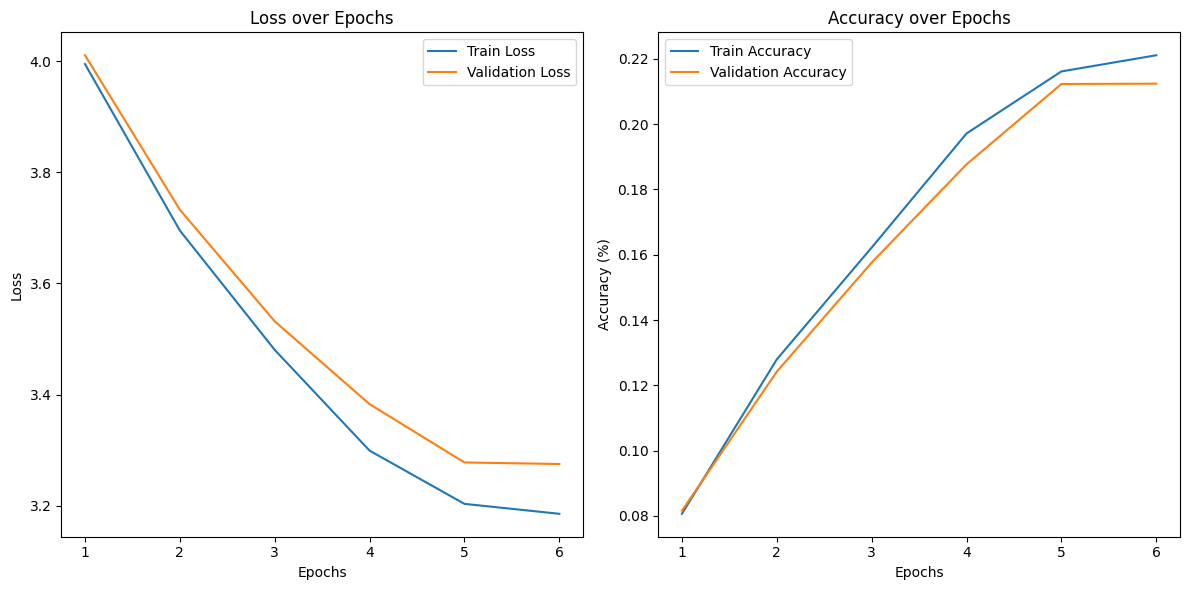

In [123]:
def split_cifar100(dataset, num_workers):
    # Generate random permutation of dataset indices
    indices = np.random.permutation(len(dataset))
    # Split indices into chunks, one for each worker
    splits = np.array_split(indices, num_workers)
    # Return subsets of the dataset for each worker
    return [torch.utils.data.Subset(dataset, split) for split in splits]

def local_training(local_models, local_optimizers, workers, worker_iters, local_steps, device, criterion):
    for worker_id in range(num_workers):
        local_models[worker_id].train()
        for _ in range(local_steps):
            try:
                inputs, labels = next(worker_iters[worker_id])
            except StopIteration:
                # If worker iterator is exhausted, reset it
                worker_iters[worker_id] = iter(workers[worker_id])
                inputs, labels = next(worker_iters[worker_id])

            inputs, labels = inputs.to(device), labels.to(device)
            local_optimizers[worker_id].zero_grad()
            outputs = local_models[worker_id](inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            local_optimizers[worker_id].step()


def calculate_global_metrics(global_model, workers, device, criterion):
    global_model.eval()
    global_train_loss, global_correct, global_total = 0.0, 0, 0
    with torch.no_grad():
        # Calculate global metrics on worker data
        for inputs, labels in workers[0]:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            loss = criterion(outputs, labels)
            global_train_loss += loss.item()
            _, predicted = outputs.max(1)
            global_correct += predicted.eq(labels).sum().item()
            global_total += labels.size(0)
    global_train_loss /= len(workers[0])
    global_train_acc = global_correct / global_total
    return global_train_loss, global_train_acc

def adjust_local_steps(epoch, val_losses, local_steps, num_epochs, hyperparams):
    # Dynamically adjust the number of local steps based on validation loss
    if epoch > 1 and len(val_losses) > 1:
        delta_loss = (val_losses[-2] - val_losses[-1]) / val_losses[-2]
        if epoch <= num_epochs * 0.2:
            delta_min = hyperparams['delta_min_initial']
        elif epoch <= num_epochs * 0.8:
            delta_min = hyperparams['delta_min_mid']
        else:
            delta_min = hyperparams['delta_min_final']

        # Increase local steps if the loss delta is small
        if 0 < delta_loss < delta_min:
            local_steps = min(local_steps * 2, hyperparams['max_local_steps'])
            print(f"Delta loss: {delta_loss} | Epoch {epoch}: Increasing local steps to {local_steps}")

        # Decrease local steps if delta_loss is negative and large
        if epoch > num_epochs * 0.3:
            if delta_loss < 0 and abs(delta_loss) > hyperparams['delta_min_initial']:
                local_steps = max(local_steps // 2, hyperparams['min_local_steps'])
                print(f"Delta loss: {delta_loss} | Epoch {epoch}: Decreasing local steps due to significant oscillation to {local_steps}")

    return local_steps

def local_sgd_adaptive_steps(train_dataset, val_loader, test_loader, device, num_workers, initial_local_steps, num_epochs, batch_size, hyperparams, verbose=False):
    dataset_size = len(train_dataset)
    datasets = split_cifar100(train_dataset, num_workers)  # Split dataset for each worker
    workers = [
        torch.utils.data.DataLoader(
            datasets[i],
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True,
        )
        for i in range(num_workers)
    ]

    # Calculate the total number of iterations for the centralized setting
    centralized_tot_iteration = (num_epochs * (dataset_size // batch_size))

    # Calculate total iterations for the model considering the local steps and workers
    model_tot_iterations = (num_epochs * (dataset_size // batch_size)) // (num_workers * initial_local_steps)

    # Determine how many iterations each worker should perform in an epoch
    iterations_per_epoch = model_tot_iterations // num_epochs
    initial_iterations_per_epoch = iterations_per_epoch
    remain_iterations = centralized_tot_iteration

    # Instantiate a time tracker for performance metrics
    time_tracker = TimeTracker()

    # Initialize checkpoint saver to manage model state persistence across iterations
    check_point_saver = CheckpointSaver(
        j=initial_local_steps,
        k=num_workers,
        hyperparams=hyperparams,
        epochs=num_epochs
    )

    # Initialize the global model
    global_model = LeNet5().to(device)

    # Load model from checkpoint if available, or initialize from scratch
    start_epoch = 0
    if os.path.exists(SAVE_PATH + CHECKPOINT_NAME):
        model_state_dict, optimizer_state_dict, start_epoch = check_point_saver.load_model_checkpoint()
        global_model.load_state_dict(model_state_dict)

        # Create a copy of the global model for each worker
        local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]

        # Initialize optimizers for each local model
        local_optimizers = [
            optim.SGD(
                model.parameters(),
                lr=hyperparams['lr'],
                weight_decay=hyperparams['weight_decay'],
                momentum=hyperparams['momentum'],
            ) for model in local_models
        ]

        # Load optimizer state from checkpoint
        for op in local_optimizers:
            op.load_state_dict(optimizer_state_dict)

        print(f"Resumed training from iteration {start_epoch}")

    else:
        print("Starting training from scratch")

        # Initialize local models and optimizers if no checkpoint exists
        local_models = [copy.deepcopy(global_model).to(device) for _ in range(num_workers)]
        local_optimizers = [
            optim.SGD(
                model.parameters(),
                lr=hyperparams['lr'],
                weight_decay=hyperparams['weight_decay'],
                momentum=hyperparams['momentum'],
            ) for model in local_models
        ]

    # Set up learning rate schedulers for each local optimizer
    schedulers = [CosineAnnealingLR(opt, T_max=num_epochs) for opt in local_optimizers]
    criterion = nn.CrossEntropyLoss()  # Loss function for classification
    local_weights = [len(datasets[i].indices) / dataset_size for i in range(num_workers)]  # Weight based on dataset size per worker

    val_losses, val_accuracies = [], []
    train_losses, train_accuracies = [], []
    local_steps = initial_local_steps
    worker_iters = [iter(workers[i]) for i in range(num_workers)]  # Iterator for each worker's data loader

    for loop_index in range(2):
        for epoch in range(start_epoch + 1, num_epochs + 1):
            # Dynamically adjust iterations per epoch based on the current local steps
            iterations_per_epoch = (dataset_size // batch_size) // (num_workers * local_steps)
            print(f"Adaptive_iterations_per_epoch: {iterations_per_epoch}")

            for iteration in range(iterations_per_epoch):
                # Training step for each worker with local steps

                time_tracker.start_computation()

                # Perform local training using the local models and optimizers
                local_training(local_models, local_optimizers, workers, worker_iters, local_steps, device, criterion)

                time_tracker.end_computation()
                time_tracker.start_communication()

                # Model averaging: aggregate the model weights from all workers
                with torch.no_grad():
                    global_state_dict = global_model.state_dict()
                    for key in global_state_dict.keys():
                        global_state_dict[key] = torch.sum(
                            torch.stack([
                                local_weights[i] * local_models[i].state_dict()[key]
                                for i in range(num_workers)
                            ]),
                            dim=0
                        )

                    global_model.load_state_dict(global_state_dict)

                    # Update the local models with the averaged global weights
                    for local_model in local_models:
                        local_model.load_state_dict(global_state_dict)

                time_tracker.end_communication()

            # Calculate global metrics after model averaging
            global_train_loss, global_train_acc = calculate_global_metrics(global_model, workers, device, criterion)

            # Store the metrics for each epoch
            train_losses.append(global_train_loss)
            train_accuracies.append(global_train_acc)

            # Evaluate validation metrics
            val_acc, val_loss = val_model(global_model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            remain_iterations = remain_iterations - (iterations_per_epoch * num_workers * local_steps)

            # Track and log time statistics
            time_tracker.record_epoch(local_steps)
            print(f"Statistics", time_tracker.str_statistics())

            # Adjust local steps dynamically based on validation loss trends
            local_steps = adjust_local_steps(epoch, val_losses, local_steps, num_epochs, hyperparams)

            # Save model checkpoints and training progress
            check_point_saver.save_checkpoint(epoch, global_train_acc, val_acc, global_train_loss, val_loss)
            check_point_saver.save_sumamry(epoch, global_train_acc, val_acc, global_train_loss, val_loss, time_tracker.str_statistics())
            check_point_saver.save_model_checkpoint(global_model, local_optimizers[0], epoch)

            print(f"Epoch {epoch} / {num_epochs} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")

            # Update learning rate after each epoch
            for scheduler in schedulers:
                scheduler.step()
            for worker_id, optimizer in enumerate(local_optimizers):
                current_lr = optimizer.param_groups[0]['lr']
                if verbose:
                    print(f"Epoch {epoch}, Worker {worker_id}: Current Learning Rate = {current_lr:.6f}")

        # Recalculate remaining epochs if more iterations are left
        if loop_index == 0:
            remain_epochs = max(1, remain_iterations // (num_workers * initial_local_steps * initial_iterations_per_epoch))
            print(f"Remain iterations:{remain_iterations}| Remain Epoch: {num_epochs}")

        num_epochs = remain_epochs
        local_steps = initial_local_steps
        last_lr = 0.0001  # Set learning rate for the second loop
        for optimizer in local_optimizers:
            for param_group in optimizer.param_groups:
                param_group['lr'] = last_lr
        new_schedulers = [
            optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
            for optimizer in local_optimizers
        ]
        schedulers = new_schedulers

    # Test the final model after training is complete
    test_acc = test_model(global_model, test_loader, device)

    # End the summary and delete checkpoint after final test
    check_point_saver.end_sumamry(test_acc)
    check_point_saver.delete_checkpoint()

    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc, num_epochs


def val_model(global_model, val_loader, criterion, device):
    global_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    return val_acc, val_loss

def test_model(global_model, test_loader, device):
    global_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    return test_acc


def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs_added, save_path=SAVE_PATH, num_epochs=NUM_EPOCHS):
    total_epochs = num_epochs + num_epochs_added
    x_vals = list(range(1, total_epochs + 1))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(x_vals, train_losses, label="Train Loss")
    plt.plot(x_vals, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    plt.subplot(1, 2, 2)
    plt.plot(x_vals, train_accuracies, label="Train Accuracy")
    plt.plot(x_vals, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy over Epochs")

    plt.tight_layout()
    plt.savefig(f"{save_path}/training_results.png")
    print(f"Training results saved to {save_path}")
    plt.show()

if __name__ == "__main__":

    hyperparams = {
        'lr': LR,
        'weight_decay': WD,
        'momentum': MOMENTUM,
        'delta_min_initial': DELTA_MIN_INITIAL,
        'delta_min_mid': DELTA_MIN_MID,
        'delta_min_final': DELTA_MIN_FINAL,
        'max_local_steps': MAX_STEPS,
        'min_local_steps': MIN_STEPS
    }

    train_loader, val_loader, test_loader = get_dataset()
    train_dataset = train_loader.dataset

    for num_workers in NUM_WORKER_LIST:
        for initial_local_steps in LOCAL_STEPS:
            print(f"In the beginning running LocalSGD with {num_workers} workers and {initial_local_steps} initial local steps")
            train_losses, val_losses, train_accuracies, val_accuracies, test_acc, num_epochs_added = local_sgd_adaptive_steps(
                train_dataset=train_dataset,
                val_loader=val_loader,
                test_loader=test_loader,
                device=DEVICE,
                num_workers=num_workers,
                initial_local_steps=initial_local_steps,
                num_epochs=NUM_EPOCHS,
                batch_size=BATCH_SIZE,
                hyperparams=hyperparams,
            )


            plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs_added=num_epochs_added)

